# The Linear Regression Model

In [2]:
# PACKAGES
%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
import statistics as st
import pandas as pd
import os
import statsmodels.api as sm
import re
from stargazer.stargazer import Stargazer

# FUNCTIONS FROM PACKAGES
from numpy.linalg import inv
from sklearn.linear_model import LinearRegression

# SEABORN THEME
scale = 0.4
W = 16*scale
H = 9*scale
sns.set(rc = {'figure.figsize':(W,H)})
sns.set_style("white")

# WORKING DIRECTORY
mywd = "/Users/echiarot/Documents/GitHub/python_learn/Class Data Science"
os.chdir(mywd)

- In this class we'll cover the Linear Regression Model (LRM), and we'll estimate its parameters with the Ordinary Least Squares (OLS) estimator. We'll go over the theory first, and then we'll apply the theory to data in Python.
- This class is based on several **sources**. The main ones are:
    - Class notes by Nicolas Berman and Daniele Rinaldo at The Geneva Graduate Institute.
    - Textbook [Econometric Analysis](https://www.amazon.com/Econometric-Analysis-William-H-Greene/dp/0135132452) by William H. Greene (sixth edition, Pearson).
    - Fiona Burlig's class [ARE 212: Multiple equation estimation](https://www.fionaburlig.com/teaching/are212).
    - Matteo Courthoud's class [Machine Learning for Economics](https://matteocourthoud.github.io/course/ml-econ/).

## Outline
- [The Mean Model (Recap)](#The-Mean-Model-(Recap))
- [The Linear Regression Model](#The-Linear-Regression-Model)
- [The Linear Regression Model in Matrix Notation](#The-Linear-Regression-Model-in-Matrix-Notation)
- [The Ordinary Least Squares (OLS) Estimator](#The-Ordinary-Least-Squares-(OLS)-Estimator)
- [Goodness of Fit with the OLS Estimator](#Goodness-of-Fit-with-the-OLS-Estimator)
- [Hypothesis Testing with the OLS Estimator](#Hypothesis-Testing-with-the-OLS-Estimator)
- [The OLS Estimator in Python](#The-OLS-Estimator-in-Python)
    - [Data](#Data)
    - [OLS Canned Routine](#OLS-Canned-Routine)
    - [Visualizing Estimated Fitted Values and Estimated Residuals](#Visualizing-Estimated-Fitted-Values-and-Estimated-Residuals)
    - [Interpretation of Regression Results](#Interpretation-of-Regression-Results)

## The Mean Model (Recap)
- The population of a variable of interest can be represented by a probability distribution. In the mean model of the population, we assume that this probability distribution is normal with mean $\beta$ and variance $\sigma^2$. For example, the distribution of CO2 emissions per capita of all countries can be represented by a normal distribution with mean, say, 5 tonnes per capita (or more generally $\beta$) and variance, say, 1 tonne per capita (or more generally $\sigma^2$). In concise notation, the mean model of the population, also called the **population model** is:
<br><br>
$$
y \sim \mathcal{N}(\beta,\,\sigma^2)
$$ 
<br>
- We can re-express the population model in regression form with the population regression equation (exact same model). In a nutshell, we consider $y$ as having a deterministic component, or mean component, given by $\beta$, and a random component, which we can refer to as $\epsilon$:
<br><br>
$$
y = \beta + \epsilon \qquad \text{with } \epsilon \sim \mathcal{N}(0,\,\sigma^2)
$$
<br>
- Let's consider now our random sample $(y_1, ..., y_N)$. We assume that each observation of the random sample is generated by an underlying process (data generating process) described by the distribution of the population, i.e. a normal distribution with mean $\beta$ and variance $\sigma^2$. For example, let's think that we are about to draw our sample of countries for which we have data on CO2 emissions per capita. We assume that there is a 95% chance that CO2 emissions per capita of the first country in our sample will be between 3 tonnes ($5-1\times2$) and 7 tonnes ($5+1\times2$). In other words, we assume that the generating process of the data for the first country follows the distribution of the population, i.e. a normal distribution with mean 5 (or more generally $\beta$) and variance 1 (or more generally $\sigma^2$). 
- Good, now let's generalize this and make this assumption(s) for all countries that we will observe in our sample. In concise notation, the mean model of the data generating process, or what we'll refer to as the **model**:
<br><br>
$$
y_i = \beta + \epsilon_i \qquad \text{with } \epsilon_i \sim \mathcal{N}(0,\,\sigma^2), \, \, \text{for } i=1,...,N
$$
<br>
- In addition, the exact same model of the data generating process can be re-expressed by explicitly listing all the assumptions we make on the process that generates the data (less concise notation). For $i=1,...,N$:
    1. **Linearity**: $ y_i = \beta + \epsilon_i $
    2. **Zero mean**: $ \mathrm{E}(\epsilon_i)=0$
    3. **Homoscedasticity and nonautocorrelation**: each disturbance $\epsilon_i$ has the same finite variance $\sigma^2$ and is uncorrelated with every other disturbance $\epsilon_j$ (i.e. the random components of the random sample are independent and identically distributed, i.i.d.)
    4. **Normal distribution**: the disturbances are normally distributed.
- We can express the mean model of the data generating process in matrix notation by defining $\boldsymbol{x}=(1, ..., 1)'$: $\boldsymbol{y} = \boldsymbol{x}\beta + \boldsymbol{\epsilon}$ with $\boldsymbol{\epsilon} \sim \mathcal{N}(\boldsymbol{0}_N,\,\sigma^2\boldsymbol{I}_N)$.
- When we do not know $\beta$ and $\sigma^2$, we need to estimate using estimators. The generic estimators for these coefficients can be denoted as $\hat{\beta}$ and $\hat{\sigma}^2$, with generic predictions $\hat{\boldsymbol{y}}=\boldsymbol{x}\hat{\beta}$ and generic residuals $\hat{\boldsymbol{\epsilon}}=\boldsymbol{y} - \boldsymbol{x}\hat{\beta}$. Specifically, always defining $\boldsymbol{x}=(1, ..., 1)'$, we have seen that we can estimate $\beta$ with the sample-mean estimator $\hat{\beta}_{SM} = (\boldsymbol{x}'\boldsymbol{x})^{-1}(\boldsymbol{x}'\boldsymbol{y}) \sim \mathcal{N}(\beta,\sigma^2(\boldsymbol{x}'\boldsymbol{x})^{-1})$, which gives sample-mean predictions $\hat{\boldsymbol{y}}_{SM}=\boldsymbol{x}\hat{\beta}_{SM}$ and sample-mean residuals $\hat{\boldsymbol{\epsilon}}_{SM}=\boldsymbol{y} - \boldsymbol{x}\hat{\beta}_{SM}$. Furthermore, $\sigma^2$ can be estimated with the sample-variance estimator $\hat{\sigma}^2_{SV} = \frac{\hat{\boldsymbol{\epsilon}}_{SM}\,'\hat{\boldsymbol{\epsilon}}_{SM}}{N-1}$ with $\hat{\sigma}^2_{SV}\frac{N-1}{\sigma} \sim \mathcal{\chi}^2_{N-1}$. We can then use the central limit theorem and the theory of statistical tests to test whether the estimates from $\hat{\beta}_{SM}$ and $\hat{\sigma}^2_{SV}$ are statistically different from zero.

## The Linear Regression Model
- When we expressed the mean model of the population in regression form, what we did was splitting the variable of interest (say CO2 emissions per capita) between a deterministic component, given by its mean (say, 5 tonnes per capita, or more generally $\beta$), and a random component, given by a disturbance with mean 0 and variance, say, 2 (or more generally $\sigma^2$).
- In the linear regression model, what we do is saying that the deterministic component, or mean component, of $y$ is no longer simply equal to $\beta$, but it's a linear function of another variable, which we call $x$. For example, we can say that, on average - as we are talking about the mean component -, CO2 emissions per capita equals a linear function of GDP per capita. The (univariate) linear regression model of the population, with the split between this new deterministic component and the random component, can be written as follows:
<br><br>
$$
y = \beta_0 + x\beta_1 + \epsilon \qquad \text{with } \epsilon|x \sim \mathcal{N}(0,\,\sigma^2)
$$
<br>
- OK let's spot the differences with the mean model of the population. First, the mean component is no longer $\beta$, but it's $\beta_0 + x\beta_1$. Second, the now have a new variable $x$, which is a random variable. Third, given that now we are saying that $y$ depends on $x$, the distribution of $y$ is now a conditional distribution on $x$. Or, in the same way, the distribution of the random part of $y$, namely $\epsilon$, is conditional on $x$. 
- Quick note: remember that the same thing of what we just wrote can be written more concisely as $y|x \sim \mathcal{N}(\beta_0+x\beta_1,\sigma^2)$, right? Goood.
- OK now let's think that we'll have to work with samples and data (with the final goal of estimating our population parameters). As usual, let's make some assumptions on how our sample of data will be generated. The underling process that generates our sample of data can be described by the following linear regression model of the data generating process:
<br><br>
$$
y_i = \beta_0 + x_i\beta_1 + \epsilon_i \qquad \text{with } \epsilon_i|x_{i} \sim \mathcal{N}(0,\,\sigma^2), \, \, \text{for } i=1,...,N
$$
<br>
- As before, the model of the data generating process can be re-expressed by explicitly listing all the assumptions we make on the data generating process (less concise notation). For $i=1,...,N$:
    1. **Linearity**: $ y_i = \beta_0 + x_{i}\beta_1 + \epsilon_i $
    2. **Zero mean**: $ \mathrm{E}(\epsilon_i|x_i)=0$.  This means that the independent variable will not carry useful information for prediction of the disturbance.
    3. **Homoscedasticity and nonautocorrelation**: each disturbance $\epsilon_i$ has the same finite conditional variance $\sigma^2$ and is uncorrelated with every other disturbance $\epsilon_j$ (i.e. the random components of the random sample are independent and identically distributed, i.i.d.)
    4. **Data generation**: $x_i$ is a random variable.
    5. **Normal distribution**: the disturbances are normally distributed conditional on $x_i$, i.e. $x_i|\epsilon_i=\mathcal{N}(0,\sigma^2)$.
- The following graph conceptualizes what we have just written for a random sample of 3 observations $(y_1,y_2,y_3)$:

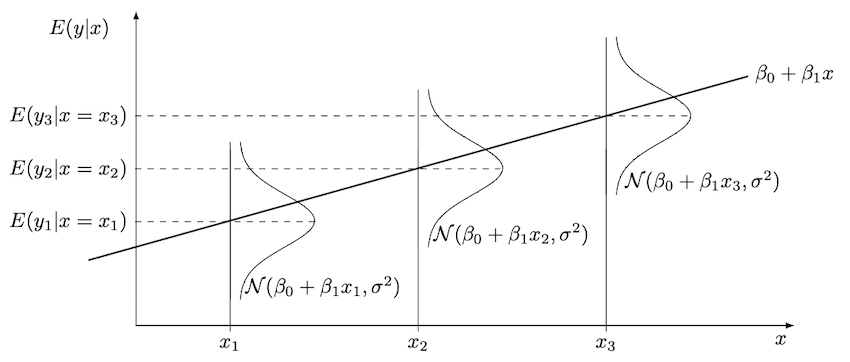

## The Linear Regression Model in Matrix Notation
- As we did for the mean model, we can express the linear regression model of the data generating process (not of the population) in matrix notation:
<br><br>
$$
\boldsymbol{y} = \boldsymbol{X}\boldsymbol{\beta} + \boldsymbol{\epsilon} \qquad \text{with } \boldsymbol{\epsilon}|\boldsymbol{X} \sim \mathcal{N}(\boldsymbol{0}_N,\sigma^2\boldsymbol{I}_N)
$$
<br>
- Let's take a moment to think about what we are writing. $\boldsymbol{y}$ is a N-dimensional random vector of the about-to-be-observed data of the variable of interest (for example, CO2 emissions per capita). $\boldsymbol{X}$ is a $N\times2$ matrix, with the first column being a N-dimensional constant vector of 1s, i.e. $(1,...,1)'$, and the second column being the N-dimensional random vector of the about-to-be-observed data of our predictor, i.e. $(x_1,...,x_N)'$ (for example GDP per capita). $\boldsymbol{\beta}$ is a 2-dimensional  vector of coefficients $(\beta_0, \beta_1)'$. $\boldsymbol{X\beta}$ represents the deterministic component of $\boldsymbol{y}$. $\boldsymbol{\epsilon}$ is a N-dimensional random vector of disturbances $(\epsilon_1,...,\epsilon_N)'$. You should write this down and expand the matrices, as we did for the sample-mean model.
- Let's then re-write the linear regression model by explicitly mentioning all the assumptions, this time using matrix notation:
    1. **Linearity**: $\boldsymbol{y} = \boldsymbol{X}\boldsymbol{\beta} + \boldsymbol{\epsilon}$
    2. **Full rank**: $\boldsymbol{X}$ is full rank, i.e. there is no exact linear relationship among any of the independent variables in the model.
    3. **Exogeneity of the independent variables**: $ \mathrm{E}(\boldsymbol{\epsilon}|\boldsymbol{X})=\boldsymbol{0}_N$. This implies $\mathrm{E}(\boldsymbol{y}|\boldsymbol{X}) = \boldsymbol{X}\boldsymbol{\beta}$.
    4. **Homoscedasticity and nonautocorrelation**: $\mathrm{V} (\boldsymbol{\epsilon}|\boldsymbol{X})=\sigma^2\boldsymbol{I}_N$. If we consider assumption 3, this assumption can be re-written as $\mathrm{E}(\boldsymbol{\epsilon}'\boldsymbol{\epsilon}|\boldsymbol{X}) = \sigma^2\boldsymbol{I}_N$.
    5. **Data generation**: $\boldsymbol{X}$ may be fixed or random.
    6. **Normal distribution**: $\boldsymbol{\epsilon}|\boldsymbol{X}$ is normally distributed.
- Note that assumptions 3, 4 and 6 together can be written using the following concise notation: $\boldsymbol{\epsilon}|\boldsymbol{X} \sim \mathcal{N}(\boldsymbol{0}_N,\sigma^2\boldsymbol{I}_N)$.

### The Ordinary Least Squares (OLS) Estimator
- $\boldsymbol{\beta}$ and $\sigma$ are unknown parameters that we want to estimate. As per usual, we'll estimate them using some estimators $\hat{\boldsymbol{\beta}}$ and $\hat{\sigma}$.
- For generic estimators $\hat{\boldsymbol{\beta}}$ and $\hat{\sigma}$ (any estimator), we can write the **generic predicted values** for $\boldsymbol{y}$, namely $\hat{\boldsymbol{y}}$, and the **generic residuals** $\hat{\boldsymbol{\epsilon}}$:
<br><br>
$$
\hat{\boldsymbol{y}}=\boldsymbol{X}\hat{\boldsymbol{\beta}}
$$
<br>
$$
\hat{\boldsymbol{\epsilon}}=\boldsymbol{y} - \hat{\boldsymbol{y}}=\boldsymbol{y} - \boldsymbol{X}\hat{\boldsymbol{\beta}}
$$
<br>
- This should look familiar. It's very similar to the generic predicted values and generic residuals of the sample-mean model, with the difference that now instead of having $\boldsymbol{x}=(1, ..., 1)'$, we have $\boldsymbol{X}$, which is a $N\times2$ matrix, with the first column being a N-dimensional constant vector of 1s, i.e. $(1, ..., 1)'$, and the second column being the N-dimensional random vector of the about-to-be-observed data of our predictor, i.e. $\boldsymbol{x}=(x_1, ..., x_N)'$.
- The Ordinary Least Squares (OLS) estimator finds $\beta$ to minimize the sum of squares of the residuals. Minimizing a function of the residuals means minimizing the distance between the regression line and the observations, or maximizing the fraction of the variance of y explained by our model. Why do we minimize the squares? Well, minimizing the simple sum of the residuals does not make sense, as negative and positive values could cancel out. Another  possibility would be to minimize the absolute value of the residuals, but this estimator does not usually have good properties, and poses technical difficulties.
- Let's go back to linear notation for a second. The OLS estimator is defined as the solution of the following **minimization problem**:
<br><br>
$$
\min_{\beta_0,\beta_1} f(\hat{\beta}_0,\hat{\beta}_1) = \sum_{i=1}^{N}(y_i - \hat{\beta}_0 - \hat{\beta}_1x_i)^2
$$
<br>
- As this funciton is always nonnegative, continuous and strictly concave, the minimization gives the following set of first order conditions:
<br><br>
$$
\begin{pmatrix}
\frac{\partial f(\hat{\beta}_0,\hat{\beta}_1)}{\partial \hat{\beta}_0} \\
\frac{\partial f(\hat{\beta}_0,\hat{\beta}_1)}{\partial \hat{\beta}_1}
\end{pmatrix} = 0 \Longleftrightarrow
\begin{pmatrix}
-2\sum_{i=1}^{N}(y_i - \hat{\beta}_{0,OLS} - \hat{\beta}_{1,OLS}x_i) \\
-2\sum_{i=1}^{N}x_i(y_i - \hat{\beta}_{0,OLS} - \hat{\beta}_{1,OLS}x_i)
\end{pmatrix} = 0
$$
<br>
- This is a system with 2 unkowns ($\hat{\beta}_0$ and $\hat{\beta}_1$) and 2 equations. We can therefore solve for $\hat{\beta}_0$ and $\hat{\beta}_1$. Let's write down the **solutions** for $\hat{\beta}_1$ and $\hat{\beta}_0$ (try to do the steps yourself):
<br><br>
$$
\hat{\beta}_{1,OLS} = \frac{\sum_{i=1}^{N}(x_i-\overline{x})(y_i-\overline{y})}{(x_i-\overline{x})^2}
$$
<br>
<br>
$$
\hat{\beta}_{0,OLS} = \overline{y}-\hat{\beta}_{OLS,1}\overline{x}
$$
<br>
- Going back to **matrix notation**, the minimization problem can be written as follows:
<br><br>
$$
\min_{\hat{\boldsymbol{\beta}}} f(\hat{\boldsymbol{\beta}}) = \hat{\boldsymbol{\epsilon}}'\hat{\boldsymbol{\epsilon}} = (\boldsymbol{y} - \boldsymbol{X}\hat{\boldsymbol{\beta}})'(\boldsymbol{y} - \boldsymbol{X}\hat{\boldsymbol{\beta}}) = \boldsymbol{y}'\boldsymbol{y} - \hat{\boldsymbol{\beta}}'\boldsymbol{X}'\boldsymbol{y} - \boldsymbol{y}'\boldsymbol{X}\boldsymbol{\hat{\beta}} + \hat{\boldsymbol{\beta}}'\boldsymbol{X}'\boldsymbol{X}\hat{\boldsymbol{\beta}}
$$
<br>
- And in matrix notation, the minimization gives the following set of first order conditions:
<br><br>
$$
\frac{\partial \hat{\boldsymbol{\epsilon}}'\hat{\boldsymbol{\epsilon}}}{\partial \hat{\boldsymbol{\beta}}} = \boldsymbol{0} \Longleftrightarrow \boldsymbol{0} - \boldsymbol{X}'\boldsymbol{y} - \boldsymbol{X}'\boldsymbol{y} + \boldsymbol{X}'\boldsymbol{X} \hat{\boldsymbol{\beta}}_{OLS} + (\hat{\boldsymbol{\beta}}_{OLS}'\boldsymbol{X}'\boldsymbol{X})' = \boldsymbol{0}
$$
<br>
- We can solve for $\hat{\boldsymbol{\beta}}_{OLS}$:
<br><br>
$$
\hat{\boldsymbol{\beta}}_{OLS} = (\boldsymbol{X}'\boldsymbol{X})^{-1}(\boldsymbol{X}'\boldsymbol{y})
$$
<br>
- Also this expression should look very familiar. It's **very similar to the expression of the sample-mean estimator** in matrix notation, with the difference that now instead of having $\boldsymbol{x}=(1, ..., 1)'$, we have $\boldsymbol{X}$, which is a $N\times2$ matrix, with the first column being a N-dimensional constant vector of 1s, i.e. $(1, ..., 1)'$, and the second column being the N-dimensional random vector of the about-to-be-observed data of our predictor, i.e. $\boldsymbol{x}=(x_1, ..., x_N)'$. So basically we can say that the  OLS estimator is just a generalization of the sample-mean estimator as we move from a simple constant random vectors of 1s, i.e. $\boldsymbol{x}=(1, ..., 1)'$, to a matrix in which the first column is this random vector of 1s and the second column is the random vector $\boldsymbol{x}$. Or, if you want, we can say that the sample-mean estimator is just a specific case of the OLS estimator with $\boldsymbol{X}=\boldsymbol{x}=(1, ..., 1)'$. Mind. Blown.
- So basically everything that we have learned from the sample-mean estimator applies to the OLS estimator, with some slight differences as the OLS is more general (but basically same thing). One slight difference is that, since now $\boldsymbol{X}$ is a mix of constants (1s) and a random variable ($\boldsymbol{x}$), the distribution of the estimator will no longer be a simple marginal distribution, but a **conditional distribution** on $\boldsymbol{X}$. So in theory we should write:
<br><br>
$$
\hat{\boldsymbol{\beta}}_{OLS}|\boldsymbol{X} = (\boldsymbol{X}'\boldsymbol{X})^{-1}(\boldsymbol{X}'\boldsymbol{y})
$$
<br>
- We, as everyone does, will mostly always write it by omitting the conditional sign, unless we are studying its moments and distribution. But let's not forget that the distribution of $\hat{\boldsymbol{\beta}}_{OLS}$ is a conditional distribution (on $\boldsymbol{X}$).
- So as we did for the sample-mean estimator in the mean model, let's say something on the distribution of $\hat{\boldsymbol{\beta}}_{OLS}$. It can be shown that, given the assumptions 1-6 of the linear regression model for the data generating process mentioned above, the OLS estimator follows a conditional normal distribution (conditional on $\boldsymbol{X}$), with conditional **mean of the OLS estimator** $\boldsymbol{\beta}$ and conditional **variance-covariance matrix of the OLS estimator** $\sigma^2(\boldsymbol{X}'\boldsymbol{X})^{-1}$. In the usual concise notation:
<br><br>
$$
\hat{\boldsymbol{\beta}}_{OLS}|\boldsymbol{X} \sim \mathcal{N}(\boldsymbol{\beta},\sigma^2(\boldsymbol{X}'\boldsymbol{X})^{-1})
$$
<br>
- Again, it should look very familiar. OK we have an estimator for $\boldsymbol{\beta}$, let's look at the estimator for $\sigma^2$. Let's define the $n\times1$ vectors of **OLS fitted (or predicted) values** and **OLS residuals**:
<br><br>
$$
\hat{\boldsymbol{y}}_{OLS}=\boldsymbol{X}\hat{\boldsymbol{\beta}}_{OLS}
$$
<br>
$$
\hat{\boldsymbol{\epsilon}}_{OLS}=\boldsymbol{y} - \hat{\boldsymbol{y}}_{OLS}= \boldsymbol{y} - \boldsymbol{X}\hat{\boldsymbol{\beta}}_{OLS}
$$
<br>
- You will not be surprised to know that an unbiased estimator for $\sigma^2$ is very similar to the **sample-variance estimator**, i.e. the sum of the least squares residuals divided by the number of degrees of freedom. In our case:
<br><br>
$$
\hat{\sigma}^2_{OLS}=\frac{\hat{\boldsymbol{\epsilon}}_{OLS}\,'\hat{\boldsymbol{\epsilon}}_{OLS}}{N-2}
$$
<br>
- As usual, we should write $\hat{\sigma}^2_{OLS}|\boldsymbol{X}$, as this estimator distributes conditionally on $\boldsymbol{X}$. The estimator $\hat{\sigma}^2_{OLS}|\boldsymbol{X}$ has conditional mean $\mathrm{E}(\hat{\sigma}^2|\boldsymbol{X})={\sigma}^2$ and conditional variance $\mathrm{V}(\hat{\sigma}^2|\boldsymbol{X})=\frac{2\sigma^4}{N-2}$, and its transformation $\hat{\sigma}^2_{OLS}\frac{N-1}{\sigma}|\boldsymbol{X}$ follows a conditional Chi-square distribution with $N-2$ degrees of freedom, i.e. $\hat{\sigma}^2_{OLS}\frac{N-1}{\sigma}|\boldsymbol{X} \sim \mathcal{\chi^2}_{(N-2)}$. In most statistical software the estimator $\hat{\sigma}^2_{OLS}$ (or more precisely $\hat{\sigma}^2_{OLS}|\boldsymbol{X}$) is called the Root Mean Squared Error (RMSE).
- As written above, the variance-covariance matrix of the OLS estimator is $\sigma^2(\boldsymbol{X}'\boldsymbol{X})^{-1}$. The diagonal elements are the variances of the respective coefficient estimators. Let $S^{kk}$ be the k-th diagonal element of $(\boldsymbol{X}'\boldsymbol{X})^{-1}$. In our case, the first diagonal element, i.e. $\sigma^2S^{11}$, is the variance of the estimator $\hat{\beta}_0$, and the second diagonal element, i.e. $\sigma^2S^{22}$, is the variance of the estimator $\hat{\beta}_1$. The square root of the first diagonal element, i.e. $\sqrt{\sigma^2S^{11}}$, is called conditional **standard error of the OLS estimator** $\hat{\beta}_0$, and the square root of the second diagonal element, i.e. $\sqrt{\sigma^2S^{22}}$, is called standard error of the estimator $\hat{\beta}_1$. If we do not know $\sigma^2$, we need to estimate it with $\hat{\sigma}^2_{OLS}$, and therefore we'll say that the estimator for the standard error of the estimator $\hat{\beta}_0$ is $\sqrt{\hat{\sigma}^2_{OLS}S^{11}}$, and that the estimator for the standard error of the estimator $\hat{\beta}_1$ is $\sqrt{\hat{\sigma}^2_{OLS}S^{22}}$.


## Goodness of Fit with the OLS Estimator
- The OLS estimator, by definition, maximizes the goodness-of-fit of the regression. The goodness-of-fit is the share of the variance of the dependent variable explained by the model (how well your model fit the data).
- Let's define the following expressions:
    - **Total Sum of Squares**: TSS = $\sum_{i=1}^{N}(y_i-\overline{y})^2$. This is the total sample variation of the dependent variable.
    - **Explained Sum of Squares**: ESS = $\sum_{i=1}^{N}(\hat{y}_{i,OLS}-\overline{y})^2$. This is the total sample variation of the OLS predicted values of the dependent variable.
    - **Sum of Squared Residuals**: SSR = $\sum_{i=1}^{N}(\hat{\epsilon}_{i,OLS})^2=\hat{\boldsymbol{\epsilon}}_{OLS}\,'\hat{\boldsymbol{\epsilon}}_{OLS}$. This is the total sample variation of the OLS residuals, i.e. of the unexplained part of the dependent variable.
- The OLS estimator minimizes the SSR. We can show that TSS = ESS + SSR. 
- The usual measure of goodness-of-fit is the the **R-Squared**, defined as the fraction of the variance of y explained by the model:
<br>
$R^2=\frac{ESS}{TSS}=\frac{\sum_{i=1}^{N}(\hat{y}_{i,OLS}-\overline{y})^2}{\sum_{i=1}^{N}(y_{i,OLS}-\overline{y})^2}=1-\frac{SSR}{TSS}=1-\frac{\hat{\boldsymbol{\epsilon}}_{OLS}\,'\hat{\boldsymbol{\epsilon}}_{OLS}}{TSS}$
<br><br>
- The fact that the $R^2$ is maximizes by the OLS estimation is a desirable property. However, one shouldn’t pay attention only to this statistic to determine whether a model is useful or not. We are in general more interested in the partial effect of a given variable.

## Hypothesis Testing with the OLS Estimator
- Again, this is going to be very similar to the sample-mean estimator. Let's test whether the coefficient $\beta_1$ is statistically different from $\beta_{1,0}$ (could be any value) at the 5% significance level. Obviously, what follows also holds for the other coefficient $\beta_0$, or to any coefficient (instead of $\beta_1$ we would write $\beta_i$).
- Under the null hypothesis $H_0: \beta_1 = \beta_{1,0}$ with known $\sigma^2$, we know that $\hat{\beta}_{1,OLS}|\boldsymbol{X} \sim \mathcal{N}(\beta_{1,0}, \sigma^2S^{11})$. When we normalize the test statistic we obtain the formula for the z-score test statistic $\frac{\hat{\beta}_{1,OLS}-\beta_{1,0}}{\sqrt{\sigma^2S^{11}}} |\boldsymbol{X} \sim \mathcal{N}(0, 1)$. When we do not know $\sigma^2$, the test statistic is called t-statistic, as it follows a t-distribution with N-2 degrees of freedom, i.e. $\frac{\hat{\beta}_{1,OLS}-\beta_{1,0}}{\sqrt{\hat{\sigma}^2_{OLS}S^{11}}} |\boldsymbol{X} \sim t_{N-2}$. It follows a t-statistic because it's the ratio of a standard normal and a Chi-square distribution (see Green for the proof). Finally, thanks to the central limit theorem we know that in large-enough samples the distribution of the t-statistic converges to a normal distribution, so we can use the usual critical value of 1.96 for the 5% significance level.
- Note that the test you'll be doing most is testing whether the population coefficient is statistically different from zero or not. In this case, we'll have that under the null hypothesis $H_0: \beta_1 = 0$, the t-statistic is $\frac{\hat{\beta}_{1,OLS}}{\sqrt{\hat{\sigma}^2_{OLS}S^{11}}} |\boldsymbol{X}$.

## The OLS Estimator in Python
- OK now we'll apply all these concepts and equations on real data using Python. When we did the sample-mean model, we considered CO2 emissions per capita from the QoG Environmental Indicators dataset (QoG-EI) database.  We found that, on average, one person emits 5.016 of **CO2 emissions** per year. In addition, looking at the p-value of 0.00000000000038846703634227, we can say that this result is statistically significant at the 1% level (the p-value is smaller than 0.01). This means that, based on our sample and assumptions, we can be pretty sure that a person emits more than 0 tons of CO2 per year. The probability that we are wrong on this claim is 0.00000000000038846703634227 %.
- Great. But let's say now we want more. Instead of just studying the average value of CO2 emissions per capita, now we want to understand what drives CO2 emissions per capita (on average). What could it be? For the sake of this exercise, let's pick something "naive". Could it be the case that the amount of **goods we consume** influences how much we emit? So, more in general, the research question would be: is capitalism driving climate change? As it is not easy to see exactly how much we consume, we could use income as a proxy, i.e. the more income we have the more we consume. So, intuitively, people with high income consume lots of carbon-intensive goods and services, i.e. they fly more, and therefore emit more.
- How do we translate this into our model? Simple. Instead of assuming that the mean component of CO2 emissions per capita is simply $\beta$, we'll assume that its mean component is $\beta_0+\beta_1x$, where $x$ is GDP per capita. In other words, we assume that, on average, CO2 emissions per capita linearly depend on the value of the GDP per capita. Or similarly, that we can use GDP per capita to predict CO2 emissions per capita.

### Data
- Let's get **QoG**:

In [3]:
# get data
link = "https://www.qogdata.pol.gu.se/data/qog_ei_sept21.xlsx"
df_qog = pd.read_excel(link)

- In QoG-EI there is no GDP per capita. But we have CO2 emissions over GDP in billions of US dollars (`edgar_co2gdp`), CO2 emissions per capita (`edgar_co2pc`) and total CO2 emissions (`edgar_co2t`). So we can infer GDP, population and GDP per capita as follows:

In [4]:
# get variables
indexes = ["ccodealp","year"]
variabs_co2 = ["edgar_co2gdp","edgar_co2t","edgar_co2pc"]
variabs_control = ["oecd_cctr_gdp"]
variabs = variabs_co2 + variabs_control
df = df_qog.loc[:,np.append(indexes,variabs)]

# make gdp per capita
df["gdp"] = (df["edgar_co2gdp"]/df["edgar_co2t"])**(-1) # billions US dollars
df["pop"] = (df["edgar_co2pc"]/df["edgar_co2t"])**(-1) # millions
df["gdp_pc"] = df["gdp"]/df["pop"] # thousands of US dollars
variabs = np.append(variabs, ["gdp","pop","gdp_pc"])

- As you noticed we've got also `oecd_cctr_gdp`, which is Climate change-related tax revenue as a percentage of gross domestic product (GDP). Includes taxes, fees and charges, tradable permits, deposit-refund systems, subsidies, and voluntary approaches related to the domain of climate change. We'll use it later on.
- This is a panel. Let's make it simple and work on a cross section for now. We'll also insert the usual column of ones:

In [5]:
# make cross section
df = df.groupby("ccodealp")[variabs].mean().reset_index().dropna()

# put ones into data
df["ones"] = 1

# size
df.describe()

,edgar_co2gdp,edgar_co2t,edgar_co2pc,oecd_cctr_gdp,gdp,pop,gdp_pc,ones
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.0
mean,0.247603,195.825199,4.830302,73.283234,650.124506,42.701446,19.251881,1.0
std,0.170606,720.872490,5.224483,32.972606,1933.409781,156.855037,17.556473,0.0
min,0.025149,0.108556,0.045539,0.000000,0.972423,0.079685,0.983474,1.0
25%,0.155786,2.905072,0.840752,61.271482,24.957702,2.646766,5.747795,1.0
50%,0.208485,16.726846,3.092004,88.059880,85.686463,8.199739,14.797901,1.0
75%,0.280334,78.159888,7.815615,97.901180,401.674269,21.892766,28.501555,1.0
max,0.935758,5229.757152,28.391528,100.000000,15228.525307,1183.106459,98.082637,1.0


- OK so our dependent variable is CO2 emissions per capita (`edgar_co2pc`) that has an average of 4.83 tonnes per year. The independent variable of interest is gdp_pc (`gdp_pc`), with mean of 19 thousand dollars per year. Let's plot them:

<AxesSubplot:xlabel='gdp_pc', ylabel='edgar_co2pc'>

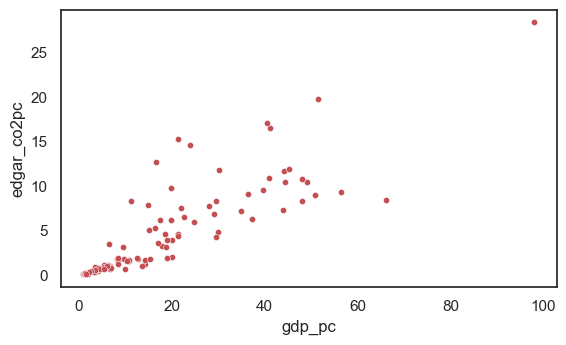

In [6]:
# plot
sns.scatterplot(x='gdp_pc', y='edgar_co2pc', data=df, color = "r", s = 20)

- OK so it looks like one country is far away from the rest of the group with GDP per capita around 100 thousand dollars per year and emissions per capita above 25 tonnes. Let's do a "quick and dirty" cleaning and drop this outlier, no further questions asked:

(94, 9)

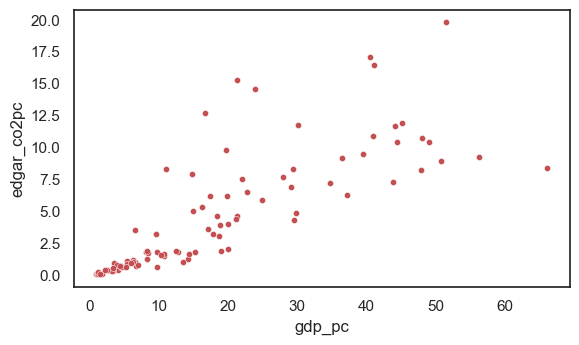

In [7]:
# drop outliers quick and dirty
df = df.loc[df["gdp_pc"] < 80,:]
sns.scatterplot(x='gdp_pc', y='edgar_co2pc', data=df, color = "r", s = 20)
df.shape

- OK looks a bit better. Now there seems to be lots of grouping for lower values of both variables, while values are more spread as both variables increase. This is a classic situation in which log transforming the variables might provide a more homogeneous grouping. Let's try it:

<AxesSubplot:xlabel='ln_gdp_pc', ylabel='ln_edgar_co2pc'>

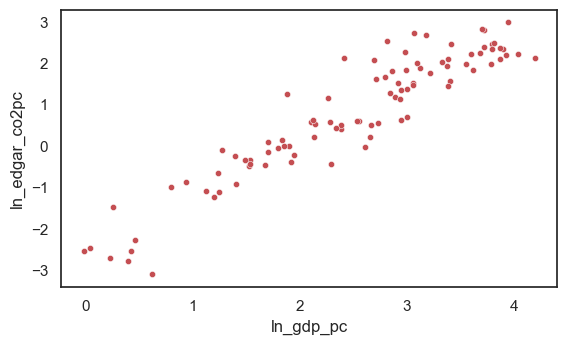

In [8]:
# maybe logs?
df["ln_gdp_pc"] = np.log(df["gdp_pc"])
df["ln_edgar_co2pc"] = np.log(df["edgar_co2pc"])
sns.scatterplot(x='ln_gdp_pc', y='ln_edgar_co2pc', data=df, color = "r", s = 20)

### OLS Canned Routine
- OK good, let's work with this data.
- We are assuming that there is a linear relationship between the log of CO2 Emissions and the log of GDP per capita (plus some randomness), i.e. the regression model of the population is $ln\_edgar\_co2pc = \beta_0 + \beta_1 ln\_gdp\_pc + \epsilon$. We can use this sample to estimate the population parameters $\beta_0$ and $\beta_1$. As we have seen above, a good estimator to estimate these parameters is the OLS estimators, which minimizes the sum of the squares of the residuals. Let's use the canned method `sm.OLS.from_formula` to get the OLS estimates for $\beta_0$ and $\beta_1$:

In [48]:
# canned ols
ols_canned_results = sm.OLS.from_formula('ln_edgar_co2pc ~ ln_gdp_pc', df).fit()
ols_canned_results_table = ols_canned_results.summary().tables[1]
ols_canned_results_table

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-2.4732,0.136,-18.124,0.000,-2.744,-2.202
ln_gdp_pc,1.3136,0.051,25.811,0.000,1.212,1.415


### Visualizing Estimated Fitted Values and Estimated Residuals
- The canned routine gives us the coefficient estimates in the first column. The other columns report respectively the estimate of the standard errors of the OLS estimators, the t statistics for the estimates, the p values for the estimates, and the 95% confidence intervals around the estimates. Let's focus in the coefficient estimates for now.
- The estimate for $\beta_0$ is $-2.4732$, and the estimate for $\beta_1$ is $1.3136$. Visually, these numbers can be interpreted as the intercept and the slope of the line of the Least Squares Fit (the code is borrowed from the really amazing [class](https://matteocourthoud.github.io/course/ml-econ/01_regression/) of Matteo Curthoud on machine learning):

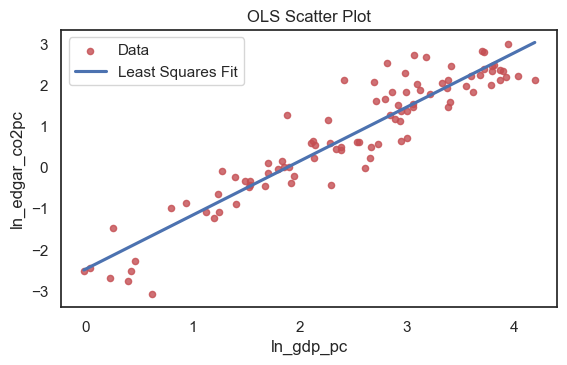

In [10]:
# graph ols
def make_OLS_scatterplot():
    
    # Init figure
    fig, ax = plt.subplots(1,1)
    ax.set_title('OLS Scatter Plot');

    # Plot scatter and best fit line
    sns.regplot(x=df.ln_gdp_pc, y=df.ln_edgar_co2pc, ax=ax, order=1, ci=None, scatter_kws={'color':'r', 's':20})
    ax.legend(['Data','Least Squares Fit']);
    
make_OLS_scatterplot()

- As the estimates of $\beta_0$ and $\beta_1$ have been obtained by minimizing the sum of the squares of the residuals, we can say that this line is the one with lowest average distance from the observations. If we worked with a different estimator than the OLS, the fit line would be in a different position.
- We can visualize the residuals as follows:

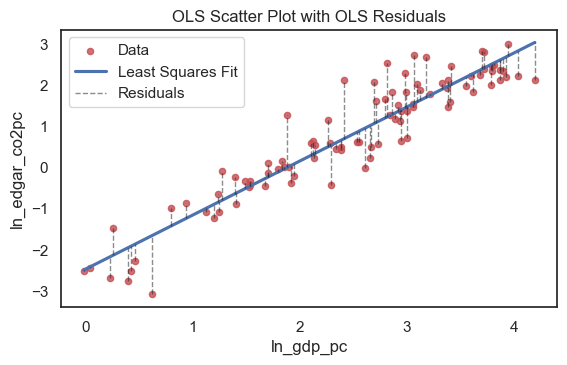

In [12]:
# get stuff
xdata = df.ln_gdp_pc.values.reshape(-1,1)
ydata = df.ln_edgar_co2pc.values
yhat_OLS = ols_canned_results.fittedvalues

# Figure 3.1
def make_OLS_scatterplot_withres():

    # Init figure
    fig, ax = plt.subplots(1,1)
    ax.set_title('OLS Scatter Plot with OLS Residuals');

    # Add residuals
    sns.regplot(x=df.ln_gdp_pc, y=df.ln_edgar_co2pc, ax=ax, order=1, ci=None, scatter_kws={'color':'r', 's':20})
    ax.vlines(xdata, np.minimum(ydata,yhat_OLS), np.maximum(ydata,yhat_OLS), linestyle='--', color='k', alpha=0.5, linewidth=1)
    plt.legend(['Data','Least Squares Fit','Residuals']);
    
make_OLS_scatterplot_withres()

### OLS By Hand
- OK so the canned routine gives us the OLS estiamates for $\beta_0$ and $\beta_1$, plus a bunch of other related statistics. That's convenient, though we'd like to understand what is behind all these estimates and numbers, wouldn't we? Of couuuurse. So let's use our knowledge of Python, our knowledge of the Python application of the sample-mean estimator and related statistics seen in the last class, and our new knowledge of the OLS equations to figure it out.
- During last class we have built some functions for the **sample-mean estimator** using matrix notation. The key formula is $\hat{\beta}_{SM} = (\boldsymbol{x}'\boldsymbol{x})^{-1}(\boldsymbol{x}'\boldsymbol{y})$, which in Python is written as `betahat_SM = (inv(xdata.T @ xdata)) @ (xdata.T @ ydata)`. Little reminder here:

In [28]:
# function to transform panda series into vectors / matrices
def data_to_matrix(data, variab_name):
    
    """ My Data to Matrix Function """
    
    # store in matrixes
    matrix = data.loc[:,variab_name].to_numpy()
    
    # make column vectors for arrays with less than 2 dimensions
    if len(matrix.shape) == 1:
        matrix = np.atleast_2d(matrix).T
        
    # return result
    return matrix

# define sample mean function
def sample_mean_estimator(data, y, X):
    
    """ My Sample Mean Function """
    
    # store in matrixes
    ydata = data_to_matrix(data, variab_name = y)
    xdata = data_to_matrix(data, variab_name = X)

    # get sample mean
    betahat_SM = (inv(xdata.T @ xdata)) @ (xdata.T @ ydata)

    # return
    return float(betahat_SM)

- As usual when we write functions we gotta test them (even if we already did so extensively last time):

In [29]:
# try
print(sample_mean_estimator(data = df, y = "edgar_co2pc", X = "ones"))
print(sample_mean_estimator(data = df, y = "ln_edgar_co2pc", X = "ones"))

4.57965062729964
0.7636079967747466


- The sample-mean estimate for CO2 emissions per capita is around 4.58 tonnes per year. Note that it's lower than the one we got in the summary statistics of the dataset a couple of cells back, which was 4.83, as we have dropped that outlier. Also it's different from the one we got last class, which was 5.02, as the sample we have now has less observations, as we included all the other variables and some countries dropped out as they had missing observations for some of these. Va bene (fair enough).
- Let's now write a function for the **OLS estimator**. As we have seen, the OLS is simply a generalization of the sample-mean estimator, as we move from a data vector $x$ with only ones to a data matrix $X$ with ones and the realizations of a random variable (GDP per capita). Since we have been super good and we wrote the function for the sample-mean estimator already in matrix form and super generalized, we don't have to change much for the one of the OLS estimator. Actually, we don't have to change anything. But still, for clarity's sake, let's change the name of the function to `OLS_estimator_simple` and how we call the object in which we store the results. Let's now call it `betahat_OLS` (all the rest is the same):

In [49]:
# define OLS estimator function
def OLS_estimator_simple(data, y, X):
    
    """ My Sample Mean Function """
    
    # store in matrixes
    ydata = data_to_matrix(data, variab_name = y)
    xdata = data_to_matrix(data, variab_name = X)

    # get OLS estimate
    betahat_OLS = (inv(xdata.T @ xdata)) @ (xdata.T @ ydata)

    # return
    return betahat_OLS

- Let's try it by adding `ln_gdp_pc` to X in the function argument:

In [47]:
# try
OLS_estimator_simple(data = df, y = "ln_edgar_co2pc", X = ["ones","ln_gdp_pc"])

array([[-2.47320649],
       [ 1.31355824]])

- Holy cannoli it works. Are these coefficient estimates the same of the canned method's?

In [32]:
ols_canned_results_table

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-2.4732,0.136,-18.124,0.000,-2.744,-2.202
ln_gdp_pc,1.3136,0.051,25.811,0.000,1.212,1.415


- For sure they are! Woah.
- OK but our results don't look nearly as cool as the ones of the canned method, which uses a `SimpleTable` to store them and display them. We don't know SimpleTables, but we do know panda dataframes! We could try to get a similar output by storing our results in a panda dataframe. To do that, we'll add a little chunk of code at the end of our `OLS_estimator_simple` function. As we are complicating this function, let's drop the "simple" and call the updated function `OLS_estimator`.
- Before doing it, a **note of caution**. Now we are adding new features directly inside the same function just for clarity. As mentioned during last class, this is not good practice, as your functions should be short, and if you need to add new features you just create new functions (rather than adding on the existing one). One example of this was carving out the part of the function for the sample-mean estimator that was translating data into matrix. As an exercise, you should do the same for what follows, and think of ways to create short functions that talk to each other.
- Back to our super long function, let's add a part that gets the parameters numbers of observations, parameters and degrees of freedom (as we'll need it later) and another one that **stores results** in a dataframe and gives it back to us:

In [51]:
# better OLS function

def OLS_estimator(data, y, X):
    
    """ My Sample Mean Function """
    
    # store in matrixes
    ydata = data_to_matrix(data, variab_name = y)
    xdata = data_to_matrix(data, variab_name = X)
    
    # get params
    N = len(ydata)
    K = xdata.shape[1]
    DF = N-K

    # get OLS estimate
    betahat_OLS = (inv(xdata.T @ xdata)) @ (xdata.T @ ydata)
    
    # get table
    df_res = pd.DataFrame(index=np.arange(K), columns=np.arange(2))
    df_res.columns = ["variable","coef"]
    df_res["variable"] = X
    df_res["coef"] = np.around(betahat_OLS, 4)

    # return
    return df_res

In [52]:
OLS_estimator(data = df, y = "ln_edgar_co2pc", X = ["ones","ln_gdp_pc"])

,variable,coef
0,ones,-2.4732
1,ln_gdp_pc,1.3136


- Suuper nice! We have also rounded the coefficients to the 4th decimal so they look very close to the canned method's, which is here:

In [35]:
ols_canned_results_table

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-2.4732,0.136,-18.124,0.000,-2.744,-2.202
ln_gdp_pc,1.3136,0.051,25.811,0.000,1.212,1.415


- The numbers match and also the style match. Now you must have noticed that ours is a little smaller, as we are missing all the nice statistics for statistical inference. Let's add them shall we? We can start with the estimates for the **standard errors** of the OLS coefficient estimators. As we have seen above, the variance-covariance matrix of the OLS estimator is $\sigma^2(\boldsymbol{X}'\boldsymbol{X})^{-1}$, and its estimator is $\hat{\sigma}^2(\boldsymbol{X}'\boldsymbol{X})^{-1}$. The estimators for the standard errors are the square roots of the diagonal elements of the estimator for variance-covariance matrix, i.e. for $\hat{\beta}_0$ is $\sqrt{\hat{\sigma}^2_{OLS}S^{11}}$ and for $\hat{\beta}_1$ is $\sqrt{\hat{\sigma}^2_{OLS}S^{22}}$.
- In Python we write $\sigma^2(\boldsymbol{X}'\boldsymbol{X})^{-1}$ as `betahat_OLS_vcov = sigma2hat_OLS * inv(xdata.T @ xdata)` (obtained with the OLS residuals and the estimator of the model's variance), and we create the vector of estimates of the standard errors with `sehat_OLS = np.atleast_2d(np.sqrt(betahat_OLS_vcov.diagonal())).T`:

In [36]:
# put in standard errors

def OLS_estimator(data, y, X):
    
    """ My Sample Mean Function """
    
    # store in matrixes
    ydata = data_to_matrix(data, variab_name = y)
    xdata = data_to_matrix(data, variab_name = X)
    
    # get params
    N = len(ydata)
    K = xdata.shape[1]
    DF = N-K

    # get OLS estimate
    betahat_OLS = (inv(xdata.T @ xdata)) @ (xdata.T @ ydata)
    
    # get standard errors
    resid_OLS = (ydata - xdata @ betahat_OLS)
    sigma2hat_OLS = (resid_OLS.T @ resid_OLS) / DF
    betahat_OLS_vcov = sigma2hat_OLS * inv(xdata.T @ xdata)
    sehat_OLS = np.atleast_2d(np.sqrt(betahat_OLS_vcov.diagonal())).T
    
    # get table
    df_res = pd.DataFrame(index=np.arange(K), columns=np.arange(3))
    df_res.columns = ["variable","coef","std err"]
    df_res["variable"] = X
    df_res["coef"] = np.around(betahat_OLS, 4)
    df_res["std err"] = np.around(sehat_OLS, 3)

    # return
    return df_res

In [37]:
# try
OLS_estimator(data = df, y = "ln_edgar_co2pc", X = ["ones","ln_gdp_pc"])

,variable,coef,std err
0,ones,-2.4732,0.136
1,ln_gdp_pc,1.3136,0.051


In [38]:
# compare
ols_canned_results_table

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-2.4732,0.136,-18.124,0.000,-2.744,-2.202
ln_gdp_pc,1.3136,0.051,25.811,0.000,1.212,1.415


- And finally let's leverage our knowledge of functions for **test statistics**, **p-values** and **confidence intervals** for the sample-mean estimates and apply it for OLS. The only difference is that now we need to obtain test statistics and the rest for 2 coefficients, rather than only one. So we'll have to create a loop. 
- Also, for the sample mean we did a large-sample version of the t-statistic, in which we assumed it distributed like a normal. As the canned routine does not make this assumption and uses the t-student distribution, with related degrees-of-freedom correction, let's also do it for our function. We have seen all of this already 2 classes ago, during which we called this test the one-sample t-test for the sample mean. It's the same thing, done again here for the OLS estimator. As we are using a t-student distribution, the Python function to get the area underneath the cumulative density function for a given t-statistic value is `stats.t.cdf`. Also, the Python to get a critical value from a given critical percentage (the inverse of `stats.t.cdf`) is `stats.t.ppf`.
- Lastly, obviously we need to add these new results to the output dataframe.

In [39]:
# put in test statistics

def OLS_estimator(data, y, X):
    
    """ My Sample Mean Function """
    
    # store in matrixes
    ydata = data_to_matrix(data, variab_name = y)
    xdata = data_to_matrix(data, variab_name = X)
    
    # get params
    N = len(ydata)
    K = xdata.shape[1]
    DF = N-K

    # get OLS estimate
    betahat_OLS = (inv(xdata.T @ xdata)) @ (xdata.T @ ydata)
    
    # get standard errors
    resid_OLS = (ydata - xdata @ betahat_OLS)
    sigma2hat_OLS = (resid_OLS.T @ resid_OLS) / DF
    betahat_OLS_vcov = sigma2hat_OLS * inv(xdata.T @ xdata)
    sehat_OLS = np.atleast_2d(np.sqrt(betahat_OLS_vcov.diagonal())).T
    
    # get t stat
    t_stat_OLS = betahat_OLS / sehat_OLS
    
    # get p values and confidence intervals
    
    # create objects to store results
    p_values_OLS = np.empty((K,1,))
    ci_low_OLS = np.empty((K,1,))
    ci_high_OLS = np.empty((K,1,))
    
    # run loop
    for i in range(K):
        
        # get p value
        lower_area = stats.t.cdf(-abs(float(t_stat_OLS[i])), df = DF)
        upper_area = lower_area
        p_value = lower_area + upper_area
        p_values_OLS[i] = p_value

        # get confidence interval
        alpha_inv = (1.0-0.05)
        q1 = (1+alpha_inv)/2
        ci_critical = stats.t.ppf(q1, DF)
        ci_low_OLS[i] = betahat_OLS[i]-(ci_critical*sehat_OLS[i])
        ci_high_OLS[i] = betahat_OLS[i]+(ci_critical*sehat_OLS[i])

    # get table
    df_res = pd.DataFrame(index=np.arange(K), columns=np.arange(7))
    df_res.columns = ["variable","coef","std err","t","P>|t|","[0.025","0.975]"]
    df_res["variable"] = X
    df_res["coef"] = np.around(betahat_OLS, 4)
    df_res["std err"] = np.around(sehat_OLS, 3)
    df_res["t"] = np.around(t_stat_OLS, 3)
    df_res["P>|t|"] = np.around(p_values_OLS, 3)
    df_res["[0.025"] = np.around(ci_low_OLS, 3)
    df_res["0.975]"] = np.around(ci_high_OLS, 3)

    # return
    return df_res

In [40]:
# try
OLS_estimator(data = df, y = "ln_edgar_co2pc", X = ["ones","ln_gdp_pc"])

,variable,coef,std err,t,P>|t|,[0.025,0.975]
0,ones,-2.4732,0.136,-18.124,0.0,-2.744,-2.202
1,ln_gdp_pc,1.3136,0.051,25.811,0.0,1.212,1.415


In [43]:
# compare
ols_canned_results_table

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-2.4732,0.136,-18.124,0.000,-2.744,-2.202
ln_gdp_pc,1.3136,0.051,25.811,0.000,1.212,1.415


- D. O. N. E. So cool.
- Of course this function is a monstrosity. As an exercise, you should tear it down to several pieces. Now it's pretty clear how you can do it. For example, you can create a function to get number of observations, parameters and degrees of freedom, a function to get standard errors and t statistics, a function to get p values and confidence intervals, and a last function to get all of these results stored in a dataframe. Making multiple functions that talk to each other will improve efficiency and debugging. That's how you write a package / library.

### Interpretation of Regression Results
- OK now that we have an understanding of what the numbers in our table are, let's interpret them. Remember that both our variables are in logs (i.e. we have a **log-log model**), so the interpretation will be in percentage points. For a summary of how to interpret coefficients with different combinations of level and logged variables check [here](https://sites.google.com/site/curtiskephart/ta/econ113/interpreting-beta) or [here](https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/).
- The coefficient estimate for `ln_gdp_pc` of 1.3136 means that, on average, if GDP per capita increases by one percent, we'd expect CO2 emissions per capita to increase by 1.3136 percent. Or, if we want to multiply by 10 to make it more meaningful, a 10-percent increase to GDP per capita leads CO2 emissions per capita to increase by 13.33 % (i.e. $(1.10^{1.3136}-1)\times100$).
- In addition, as the p-value is lower than 5%, we can infer that, based on our sample and estimate, we can be pretty sure that the population parameter's $\beta_1$ is different than zero (the probability that we are making a mistake when making this argument is 0.000 ... etc). We can get to the same conclusion by noticing that the 95%-confidence interval of the coefficient estimate does not contain 0.
- What if we wanted to study the effect of an increase in 1000 US dollars of GDP per capita on the tonnes of CO2 per capita, rather than a 1% or a 10% increase? Well, we'd have to estimate a **level-level model**:

In [44]:
# level level
OLS_estimator(data = df, y = "edgar_co2pc", X = ["ones","gdp_pc"])

,variable,coef,std err,t,P>|t|,[0.025,0.975]
0,ones,0.1874,0.445,0.421,0.675,-0.697,1.072
1,gdp_pc,0.2385,0.018,12.904,0.000,0.202,0.275


- So if GDP per capita increases by 1000 dollars, on average we'd expect CO2 emissions per capita to increase by approximately a quarter of a tonne (0.2385). Or in the same way, people in countries where GDP per capita is 1000 dollars higher than in other countries emit 0.2385 tonnes more than other countries.
- Finally, we did not interpret the **intercept** as its interpretation does not have much economic sense. For example, 0.1874 means that the average CO2 emissions per capita when GDP per capita is zero is around 0.18 tonnes. However GDP per capita is never zero, and that's why the estimate of $\beta_0$ does not have much economic sense. However, it is always good practice to include the constant in a regression model, as (i) it usually improves the estimates, (ii) otherwise we should come up with a reason of why it should not be there (which is usually hard to do), (iii) now we are fond of it as it allowed us to learn the mean model (even though now has a different meaning). Long story short, make sure you always have it.

- Finally, you must have noticed that these tables we worked with are not the same of **standard regression tables** in academic papers. There is a way to get those too, using the Stargazer package:

In [45]:
stargazer = Stargazer([ols_canned_results])
stargazer

- "Loook at the starts, looook how they shiine foooor you". OK thank you Chris Martin, though all you are adding to our former table is just a nice sparkling way to see if results are statistically significant at the 1-percent level (3 stars 1 percent, 2 starts 5 percent, 1 star 10 percent). Why not.
- Finally also note that this table shows R-squared adn Adjusted R-squared. We did not do the adjusted yet (and rightfully so as they are the same in our case). But we can interpret the R-squared. As seen above:
<br>
$R^2=\frac{ESS}{TSS}=\frac{\sum_{i=1}^{N}(\hat{y}_{i,OLS}-\overline{y})^2}{\sum_{i=1}^{N}(y_{i,OLS}-\overline{y})^2}=1-\frac{SSR}{TSS}=1-\frac{\hat{\boldsymbol{\epsilon}}_{OLS}\,'\hat{\boldsymbol{\epsilon}}_{OLS}}{TSS}$
<br><br>
- So an **R-Squared** of 0.88 means that the fit line (or prediction) explain around 88% of the variation in our data. Indeed, you saw in the scatterplot how our fit line was nicely fitting the cloud of data points. Not bad. There isn't a right or wrong level of R-Squared, so we should always interpret it with caution. For sure, if it's like 0.00001, then that's a red flag that our OLS fit line is not doing a very good job in fitting the data.